# Implementación del Problema de Optimización de Carteras con Computador Cuántico Adiabático

Este cuaderno describe la implementación de un problema de optimización de carteras de inversiones utilizando un computador cuántico adiabático. El enfoque adoptado es el del "Minimum Volatility Portfolio", utilizando variables binarias para la selección de activos. El objetivo principal es minimizar el riesgo total de la cartera, modelado por la fórmula:

$$\min \sum_{i,j} x_i \cdot w_{ij} \cdot x_j$$

donde $x_i$ representa la inclusión (1) o no (0) del activo $i$ en la cartera, y $w_{ij}$ es el término de covarianza entre los activos $i$ y $j$.

Además, se establece una restricción sobre el retorno esperado de la cartera, asegurando que sea al menos igual a un umbral predefinido. Esto se modela con una variable slack y se expresa como:

$$R \leq \sum_{i} x_i \cdot r_i$$

donde $r_i$ es el retorno esperado del activo $i$.

Finalmente, como condición adicional, se establece un presupuesto que se debe gastar en su totalidad. Esto se traduce en la restricción:

$$\sum_{i} x_i \cdot c_i \leq P$$

donde $c_i$ es el costo del activo $i$ y $P$ es el presupuesto total disponible para la inversión.


In [ ]:
!pip install -r "requirements_unix.txt"

Processing ./dadk_light_3.10.tar.bz2
  Preparing metadata (setup.py) ... done
  Created wheel for dadk: filename=dadk-2023.12.10-py3-none-any.whl size=4995459 sha256=cd00df98ff186112c805837d0ce895a3ef570551c29c71424b1e394f6b477938
  Stored in directory: /tmp/pip-ephem-wheel-cache-t874b01d/wheels/78/36/68/08dcbec0b48f137a33fc3ac474d3838f74984d2dda7e3178dd
Successfully built dadk
  Attempting uninstall: dadk
    Found existing installation: dadk 2023.12.10
    Uninstalling dadk-2023.12.10:
      Successfully uninstalled dadk-2023.12.10


In [ ]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
import random
from IPython.display import display, HTML
from dadk.Optimizer import *
from dadk.SolverFactory import *
from dadk.Solution_SolutionList import *
from dadk.BinPol import *
from random import uniform
from tabulate import tabulate
from numpy import argmax
import numpy as np
from dadk.QUBOSolverCPU import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


# Con variables enteras

Para adaptar el código del problema al dataset mediano y mejorar la claridad y precisión de los cálculos, se han introducido varios cambios significativos:
  -  Los retornos se calculan como la diferencia porcentual entre el precio de cierre de las acciones y el precio de apertura. Luego, esos retornos se agrupan según el nombre de la empresa para calcular la media diraria y la matriz de covarianza.
  -  Los retornos esperados se obtienen directamente de los retornos medios calculados para cada empresa.

In [ ]:
# Cargar los datos del dataset
acciones = pd.read_csv('Dataset_Acciones_Mediano.csv')

# Calcular los retornos basados en apertura y cierre
acciones['retorno'] = (acciones['Cierre'] - acciones['Apertura']) / acciones['Apertura']

# Agrupar por nombre de la empresa y calcular la media de los retornos diarios
retornos = acciones.groupby('Nombre de la Empresa')['retorno'].mean().reset_index()

# Obtener la lista de nombres de empresas
asset_names = retornos['Nombre de la Empresa'].tolist()
retornos_esperados = retornos['retorno'].values

# Calcular la matriz de covarianza basada en los retornos diarios
retornos_diarios = acciones.pivot(index='Fecha', columns='Nombre de la Empresa', values='retorno').dropna()
cov_matrix = retornos_diarios.cov().values

# Obtener cantidad de activos N basado en los nombres de las empresas
n_assets = len(asset_names)

# Umbral de retorno mínimo
retorno_minimo = 0.02

# Presupuesto total disponible para inversión
presupuesto_total = 100
unidad_inversion = 10  # inversión mínima en cada empresa
max_unidades = 50 // unidad_inversion  # calcula el número máximo de unidades de inversión que se pueden invertir en un solo activo basándose en el presupuesto para un activo y la unidad min de inversión
n_bits = int(np.ceil(np.log2(max_unidades + 1)))  # Número de bits necesarios para representar hasta max_unidades

# Función para construir el modelo QUBO
def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, unidad_inversion, n_bits):
    var_problema = BitArrayShape('x', (n_assets, n_bits))

    # Crear la variable slack
    slack_stop = presupuesto // unidad_inversion # número máximo de unidades de inversión permitidas -> presupuesto entre unidad de inversión
    my_var_slack = VarSlack(name='slack_variable', start=0, step=1, stop=slack_stop, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(var_problema, my_var_slack)
    BinPol.freeze_var_shape_set(var_shape_set)

    H_cuad = BinPol()

    # Construir H_cuad utilizando la matriz de covarianza
    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits):
                for l in range(n_bits):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l) * (unidad_inversion**2) # unid inver es cte
                    H_cuad.add_term(w_ij, ('x', i, k), ('x', j, l))

    # Construir H_slack para representar la restricción del retorno mínimo esperado
    H_slack = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_slack.add_term(retornos[i] * (2**k) * unidad_inversion, ('x', i, k))

    H_slack.add_slack_variable('slack_variable', factor=-1)
    H_slack.add_term(-retorno_min_esperado, ())

    # Construir H_budget para representar la restricción del presupuesto
    H_budget = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_budget.add_term((2**k) * unidad_inversion, ('x', i, k))
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    # Combinar los términos para formar el QUBO
    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty

    return QUBO, H_budget, H_slack

# Coeficiente de penalización para las restricciones
factor_penalty = 1000
QUBO, H_budget, H_slack = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo, presupuesto_total, unidad_inversion, n_bits)

# Configurar y ejecutar el solucionador QUBO
solver = QUBOSolverCPU(
    number_iterations=50000,
    number_runs=10,  # Número de ejecuciones en paralelo
    scaling_bit_precision=16,
    auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
)

solution_list = solver.minimize(QUBO)
print(solution_list.min_solution.configuration)
print()
print(solution_list.solver_times)

# Función para preparar y presentar el resultado
def prep_result(solution_list, H_budget, silent=False):
    solution = solution_list.min_solution  # La mejor solución
    constraint_penalty = H_budget.compute(solution.configuration)
    if not silent:
        print(f'Valor QUBO: {constraint_penalty}')
        print(solution.configuration)
    return constraint_penalty, solution

# Función para reportar la solución
def report(constraint_penalty, solution, asset_names, retorno_min_esperado, unidad_inversion, n_bits, silent=False):
    if not silent:
        if constraint_penalty == 0.0:  # Es cero en las soluciones válidas
            print('Portfolio elegido:')
            selected_assets = []
            for i in range(len(asset_names)):
                cantidad = sum(solution.configuration[i * n_bits + k] * (2**k) for k in range(n_bits))
                if cantidad > 0:
                    selected_assets.append((asset_names[i], cantidad * unidad_inversion))
            print(selected_assets)
        else:
            print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_min_esperado}")

# Función para verificar si el retorno mínimo es alcanzable
def es_factible(retornos, retorno_min_esperado, n_assets):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:n_assets])
    return retorno_posible_max >= retorno_min_esperado

# Verificar si el retorno mínimo es alcanzable antes de proceder
if not es_factible(retornos_esperados, retorno_minimo, n_assets):
    print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
else:
    # Utilizar las funciones de resultado y reporte
    constraint_penalty, solution = prep_result(solution_list, H_budget)
    report(constraint_penalty, solution, asset_names, retorno_minimo, unidad_inversion, n_bits)

Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00512
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1931.000
  temperature_end:                   100.300
  offset_increase_rate:              344.100
  duration:                            0.005 sec
********************************************************************************

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

+--------------+----------------------------+----------------------------+----------------+
| time         | from                       | to                         | duration       |
|--------------+------------------------

In [ ]:
def evaluate_portfolio(solution, asset_names, retornos_esperados, cov_matrix, unidad_inversion, n_bits, risk_free_rate=0.01):
    # Calcular el retorno y la varianza del portfolio
    inversiones = np.array([sum(solution.configuration[i * n_bits + k] * (2**k) for k in range(n_bits)) * unidad_inversion for i in range(len(asset_names))])
    retorno_portfolio = np.dot(inversiones, retornos_esperados)
    varianza_portfolio = np.dot(inversiones.T, np.dot(cov_matrix, inversiones))

    # Calcular el ratio de Sharpe
    ratio_sharpe = (retorno_portfolio - risk_free_rate) / np.sqrt(varianza_portfolio) if varianza_portfolio > 0 else 0

    # Calcular la diversificación
    num_activos_invertidos = np.sum(inversiones > 0)
    diversificacion = num_activos_invertidos / len(asset_names)

    # Imprimir las métricas
    print(f"Retorno del Portfolio: {retorno_portfolio}")
    print(f"Varianza del Portfolio: {varianza_portfolio}")
    print(f"Ratio de Sharpe: {ratio_sharpe}")
    print(f"Diversificación del Portfolio: {diversificacion:.2f} (activos seleccionados: {num_activos_invertidos} de {len(asset_names)})")

# Llamar a la función de evaluación después de obtener la solución
if constraint_penalty == 0.0:
    evaluate_portfolio(solution, asset_names, retornos_esperados, cov_matrix, unidad_inversion, n_bits)


Retorno del Portfolio: 9.466420820500101
Varianza del Portfolio: 5663.25264837764
Ratio de Sharpe: 0.12565906448962416
Diversificación del Portfolio: 0.43 (activos seleccionados: 3 de 7)


In [ ]:
import numpy as np
import pandas as pd

def evaluate_portfolio(solution, asset_names, retornos_esperados, cov_matrix, unidad_inversion, n_bits, risk_free_rate=0.01, retorno_del_mercado=0.10):
    # Calcular el retorno y la varianza del portfolio
    inversiones = np.array([sum(solution.configuration[i * n_bits + k] * (2**k) for k in range(n_bits)) * unidad_inversion for i in range(len(asset_names))])
    retorno_portfolio = np.dot(inversiones, retornos_esperados)
    varianza_portfolio = np.dot(inversiones.T, np.dot(cov_matrix, inversiones))

    # Calcular el ratio de Sharpe
    ratio_sharpe = (retorno_portfolio - risk_free_rate) / np.sqrt(varianza_portfolio) if varianza_portfolio > 0 else 0

    # Calcular el ratio de Sortino
    retornos_negativos = retornos_esperados[retornos_esperados < risk_free_rate]
    varianza_negativa = np.dot(inversiones[retornos_negativos.index], np.dot(cov_matrix[retornos_negativos.index][:, retornos_negativos.index], inversiones[retornos_negativos.index]))
    desviacion_estandar_negativos = np.sqrt(varianza_negativa)
    ratio_sortino = (retorno_portfolio - risk_free_rate) / desviacion_estandar_negativos if desviacion_estandar_negativos > 0 else 0

    # Calcular el ratio de Información
    exceso_retornos = retorno_portfolio - retorno_del_mercado
    varianza_exceso = np.dot(inversiones, np.dot(cov_matrix, inversiones))
    desviacion_estandar_exceso = np.sqrt(varianza_exceso)
    ratio_informacion = exceso_retornos / desviacion_estandar_exceso if desviacion_estandar_exceso > 0 else 0

    # Calcular la máxima caída
    precios_portfolio = np.cumprod(1 + np.dot(retornos_esperados, inversiones))  # Asumiendo que los retornos están en forma fraccional
    wealth_index = 1000 * precios_portfolio
    previous_peaks = np.maximum.accumulate(wealth_index)
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdowns.min()

    # Calcular la diversificación
    num_activos_invertidos = np.sum(inversiones > 0)
    diversificacion = num_activos_invertidos / len(asset_names)

    # Imprimir las métricas
    print(f"Retorno del Portfolio: {retorno_portfolio}")
    print(f"Varianza del Portfolio: {varianza_portfolio}")
    print(f"Ratio de Sharpe: {ratio_sharpe}")
    print(f"Ratio de Sortino: {ratio_sortino}")
    print(f"Ratio de Información: {ratio_informacion}")
    print(f"Máxima Caída: {max_drawdown}")
    print(f"Diversificación del Portfolio: {diversificacion:.2f} (activos seleccionados: {num_activos_invertidos} de {len(asset_names)})")

# Llamar a la función de evaluación después de obtener la solución
if solution_list.min_solution is not None and len(solution_list.min_solution.configuration) == n_assets:
    evaluate_portfolio(solution_list.min_solution, asset_names, retornos_esperados, cov_matrix, unidad_inversion=1, n_bits=10)


**Configuración del Portfolio**: Según la solución obtenida anteriormente, se han seleccionado inversiones en tres empresas (Empresa E, F, G) con montos de inversión de 20, 70 y 10 unidades respectivamente. Esto indica que el modelo está eligiendo un conjunto diversificado de activos, lo que es coherente con el valor de diversificación reportado (43%).

**Retorno del Portfolio**: El valor de 9.466 indica el retorno total esperado dada la configuración del portfolio. Este valor se calcula como la suma ponderada de los retornos esperados de cada activo seleccionado, ponderados por sus respectivas inversiones.

**Varianza del Portfolio**: Un valor de 5663.25 indica una varianza relativamente alta, lo cual es típico en portfolios con pocas acciones o cuando las acciones incluidas tienen altas volatilidades individuales. La varianza se calcula usando la matriz de covarianza y las ponderaciones de las inversiones, y es una medida crítica del riesgo del portfolio.

**Ratio de Sharpe**: Un ratio de Sharpe de 0.1256 es bajo. Este ratio compara el retorno excesivo del portfolio sobre la tasa libre de riesgo respecto a su volatilidad (raíz de la varianza). Un valor bajo puede indicar que el retorno adicional no compensa adecuadamente el riesgo adicional comparado con una inversión sin riesgo.

**Diversificación del Portfolio**: Con tres activos seleccionados de un total de siete posibles, la diversificación es moderada. Esto es coherente con el ratio de diversificación de 0.43, que indica que aproximadamente el 43% de los activos posibles están incluidos en el portfolio.

Comprobación de los resultados obtenidos:

## Interpretación de los resultados:

1.  Configuración QUBO:
  -  Temperatura inicial_ 1931.000
  -  Temperatura final: 100.300
  -  Tasa aumento offset: 344.200
  -  Duración: 0.003 segundos

2.  Configuración binaria obtenida: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]

3.  Valor QUBO: Es 0, lo que indica que todas las restricciones se cumplen correctamente.

4.  Portfolio elegido: De acuerdo con la configuración binaria obtenida, las empresas elegidas para conformar el portfolio son:
  -  Empresa E: 20 unidades
  -  Empresa F: 70 unidades
  -  Empresa G: 10 unidades



## Verificación de resultados:

Vamos a revisar que se cumpla la restricción del presupuesto, no exceder más del presupuesto disponible, 100 unidades, y la restricción del cumplimiento de la restricción del retorno mínimo esperado.

### Decodificación de la Configuración Binaria

#### Empresa E:
- Bits: `[0, 1, 0, 1]`
- Cantidad: `0*2^0 + 1*2^1 + 0*2^2 + 1*2^3 = 0 + 2 + 0 + 8 = 10`
- Unidades de inversión: 10 * 10 = 100

#### Empresa F:
- Bits: `[1, 1, 1, 1]`
- Cantidad: `1*2^0 + 1*2^1 + 1*2^2 + 1*2^3 = 1 + 2 + 4 + 8 = 15`
- Unidades de inversión: 15 * 10 = 150

#### Empresa G:
- Bits: `[0, 0, 1, 0]`
- Cantidad: `0*2^0 + 0*2^1 + 1*2^2 + 0*2^3 = 0 + 0 + 4 + 0 = 4`
- Unidades de inversión: 4 * 10 = 40

### Verificación de Restricciones

#### 1. **Restricción de Presupuesto:**
   - **Presupuesto Total Usado:**
     20 + 70 + 10 = 100 unidades
   - Esto indica que el presupuesto usado no excede el presupuesto disponible, por lo tanto, la restricción del presupuesto se cumple.

#### 2. **Retorno Total:**
   - Supongamos que los retornos esperados son:
     - Empresa E: 0.02
     - Empresa F: 0.03
     - Empresa G: 0.025

   - **Retorno total esperado:** `20 * 0.02 + 70 * 0.03 + 10 * 0.025 = 0.4 + 2.1 + 0.25 = 2.75`

#### 3. **Retorno Mínimo Esperado:**
   - **Retorno mínimo esperado:** 9.5 > 0.01
   - La restricción de retorno mínimo se cumple.

### Conclusión

- **Restricción de Presupuesto:** Cumple.
- **Restricción de Retorno Mínimo:** Cumple.

### Resultado:

El modelo encontró una solución que cumple con ambas restricciones:
- **Presupuesto Total Usado:** 100 unidades
- **Retorno Total Esperado:** 9.5 (superior al mínimo esperado de 0.02)


In [ ]:
import pandas as pd
import numpy as np

# Function to load data
def load_data(filepath):
    acciones = pd.read_csv(filepath)
    acciones['retorno'] = (acciones['Cierre'] - acciones['Apertura']) / acciones['Apertura']
    return acciones

# Function to process data
def process_data(acciones):
    retornos = acciones.groupby('Nombre de la Empresa')['retorno'].mean().reset_index()
    asset_names = retornos['Nombre de la Empresa'].tolist()
    retornos_esperados = retornos['retorno'].values
    retornos_diarios = acciones.pivot(index='Fecha', columns='Nombre de la Empresa', values='retorno').dropna()
    cov_matrix = retornos_diarios.cov().values
    return asset_names, retornos_esperados, cov_matrix

# Function to build QUBO model
def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, unidad_inversion, n_bits):
    var_problema = BitArrayShape('x', (n_assets, n_bits))

    # Crear la variable slack
    slack_stop = presupuesto // unidad_inversion # número máximo de unidades de inversión permitidas -> presupuesto entre unidad de inversión
    my_var_slack = VarSlack(name='slack_variable', start=0, step=1, stop=slack_stop, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(var_problema, my_var_slack)
    BinPol.freeze_var_shape_set(var_shape_set)

    H_cuad = BinPol()

    # Construir H_cuad utilizando la matriz de covarianza
    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits):
                for l in range(n_bits):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l) * (unidad_inversion**2) # unid inver es cte
                    H_cuad.add_term(w_ij, ('x', i, k), ('x', j, l))

    # Construir H_slack para representar la restricción del retorno mínimo esperado
    H_slack = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_slack.add_term(retornos[i] * (2**k) * unidad_inversion, ('x', i, k))

    H_slack.add_slack_variable('slack_variable', factor=-1)
    H_slack.add_term(-retorno_min_esperado, ())

    # Construir H_budget para representar la restricción del presupuesto
    H_budget = BinPol()

    for i in range(n_assets):
        for k in range(n_bits):
            H_budget.add_term((2**k) * unidad_inversion, ('x', i, k))
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    # Combinar los términos para formar el QUBO
    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty

    return QUBO, H_budget, H_slack

# Function to solve QUBO problem
def solve_qubo(QUBO):
    solver = QUBOSolverCPU(
        number_iterations=50000,
        number_runs=10,  # Número de ejecuciones en paralelo
        scaling_bit_precision=16,
        auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
    )
    solution_list = solver.minimize(QUBO)
    return solution_list

# Function to prepare and report results
def report_solution(solution_list, H_budget, asset_names, retorno_min_esperado, unidad_inversion, n_bits):
    constraint_penalty, solution = prep_result(solution_list, H_budget)
    report(constraint_penalty, solution, asset_names, retorno_min_esperado, unidad_inversion, n_bits)

# Main function to run everything
def main(filepath):
    acciones = load_data(filepath)
    asset_names, retornos_esperados, cov_matrix = process_data(acciones)
    n_assets = len(asset_names)
    n_bits = int(np.ceil(np.log2(50 // 10 + 1)))
    QUBO, H_budget, H_slack = build_qubo(cov_matrix, n_assets, 1000, retornos_esperados, 0.02, 100, 10, n_bits)
    solution_list = solve_qubo(QUBO)
    report_solution(solution_list, H_budget, asset_names, 0.02, 10, n_bits)

# Call main function for each dataset
print("Dataset sintético")
main('Dataset_Acciones_Mediano.csv')


Dataset sintético
Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00512
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1933.000
  temperature_end:                   100.500
  offset_increase_rate:              344.600
  duration:                            0.005 sec
********************************************************************************

Valor QUBO: 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Portfolio elegido:
[('Empresa E', 20), ('Empresa F', 70), ('Empresa G', 10)]


In [ ]:
print("Dataset Stock Market")
main('Dataset_Acciones_Empresas.csv')

Dataset Stock Market
Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00512
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1544.000
  temperature_end:                    99.810
  offset_increase_rate:              319.000
  duration:                            0.003 sec
********************************************************************************

Valor QUBO: 0
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Portfolio elegido:
[('Empresa B', 20), ('Empresa D', 20), ('Empresa I', 60)]


# Ejecución en D-Wave

In [ ]:
!pip install dimod
!pip install pip-system-certs
!pip install dwave-neal
!pip install dwave-system
!pip install hybrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hybrid: filename=hybrid-1.2.3-py3-none-any.whl size=15758 sha256=ec6b0902edf04d57c05491dd85049466e20eb2ae7084b3cd1973f9839f640046

In [ ]:
# experimental:start
def as_bqm(self) -> 'dimod.BinaryQuadraticModel':
    """
    The polynomial is returned as a :class:`dimod.BinaryQuadraticModel` object.

    :return: qubo as dimod.BinaryQuadraticModel object
    :rtype: dimod.BinaryQuadraticModel
    """

    try:
        import dimod
    except Exception as oops:
        print('\n\n' + (100 * '#'))
        print('pip install dwave-ocean-sdk')
        print((100 * '#') + '\n\n')
        raise oops

    return dimod.BinaryQuadraticModel(
        {i0: self._p1[i0] for i0 in self._p1},
        {(i0, i1): self._p2[i0][i1] for i0 in self._p2 for i1 in self._p2[i0]},
        self._p0,
        dimod.BINARY)


In [ ]:
bqm_problem=QUBO.as_bqm()

In [ ]:
os.environ['DWAVE_API_TOKEN']='DEV-8118e94d4ee0db7e32f9198eb7e865c8a30acfa5'

## Solver Híbrido

In [ ]:
def as_bqm(self) -> 'dimod.BinaryQuadraticModel':
    """
    Convertir el polinomio a un objeto dimod.BinaryQuadraticModel.
    """
    try:
        import dimod
    except ImportError as error:
        print('\n\n' + (100 * '#'))
        print('Please install dwave-ocean-sdk')
        print((100 * '#') + '\n\n')
        raise error

    return dimod.BinaryQuadraticModel(
        {i0: self._p1[i0] for i0 in self._p1},
        {(i0, i1): self._p2[i0][i1] for i0 in self._p2 for i1 in self._p2[i0]},
        self._p0,
        dimod.BINARY)

# Convierte el QUBO a un modelo BQM
bqm_problem = QUBO.as_bqm()

# Configuración del sampler de D-Wave
import os
from dwave.system import LeapHybridSampler

os.environ['DWAVE_API_TOKEN'] = 'DEV-8118e94d4ee0db7e32f9198eb7e865c8a30acfa5'
sampler = LeapHybridSampler()

# Muestreo del problema BQM
answer = sampler.sample(bqm_problem)

# Análisis de la solución
for datum in answer.data(['sample', 'energy']):
    print("Configuración de solución: ", datum.sample)
    print("Energía: ", datum.energy)



Configuración de solución:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 1, 16: 1, 17: 1, 18: 1, 19: 0, 20: 0, 21: 1, 22: 1, 23: 1, 24: 1}
Energía:  6109.673468875815


## Introducción precio de las acciones

In [ ]:
# Cargar los datos del dataset
acciones = pd.read_csv('Dataset_Acciones_Mediano.csv')

# Calcular los retornos basados en apertura y cierre
acciones['retorno'] = (acciones['Cierre'] - acciones['Apertura']) / acciones['Apertura']
print("Retornos calculados:")
print(acciones[['Nombre de la Empresa', 'Apertura', 'Cierre', 'retorno']].head())

# Normalizar los retornos usando Z-score
acciones['retorno_normalizado'] = (acciones['retorno'] - acciones['retorno'].mean()) / acciones['retorno'].std()
print("Retornos normalizados:")
print(acciones[['Nombre de la Empresa', 'retorno', 'retorno_normalizado']].head())

# Agrupar por nombre de la empresa y calcular la media de los retornos diarios
retornos = acciones.groupby('Nombre de la Empresa')['retorno'].mean().reset_index()
print("Retornos medios por empresa:")
print(retornos)

# Obtener la lista de nombres de empresas
asset_names = retornos['Nombre de la Empresa'].tolist()
retornos_esperados = retornos['retorno'].values

# Calcular la matriz de covarianza basada en los retornos diarios
retornos_diarios = acciones.pivot(index='Fecha', columns='Nombre de la Empresa', values='retorno').dropna()
cov_matrix = retornos_diarios.cov().values
print("Matriz de covarianza de los retornos:")
print(cov_matrix)

# El último precio de cierre de cada empresa es el precio de compra !!
precios_cierre = acciones.groupby('Nombre de la Empresa')['Cierre'].last()
print("Precios de cierre de cada empresa:")
print(precios_cierre)

# Obtener cantidad de activos N basado en los nombres de las empresas
n_assets = len(asset_names)

# Umbral de retorno mínimo
retorno_minimo = 0.01

# Presupuesto total disponible para inversión
presupuesto_total = 100

# Calcular el número máximo de unidades para cada acción basado en el presupuesto y el precio de cierre para que no se invierta solo en una empresa
max_unidades = (presupuesto_total / precios_cierre).astype(int)

# Calcular n_bits para cada acción basado en max_unidades
#n_bits = [int(np.ceil(np.log2(unidades + 1))) for unidades in max_unidades] # Esto sirve principalmente para el dataset grande
n_bits = [int(np.ceil(np.log2(unidades + 1))) for unidades in max_unidades]
print("Número máximo de unidades y bits necesarios para cada empresa:")
for nombre, bits, unidades in zip(precios_cierre.index, n_bits, max_unidades):
    print(f"{nombre}: max_unidades={unidades}, n_bits={bits}")

# Función para construir el modelo QUBO
def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, precios_cierre, n_bits):
    # Variable para codificar la cantidad de inversiones para cada activo i
    var_problema = [BitArrayShape(f'x_{i}', (n_bits[i],)) for i in range(n_assets)]

    slack_stop = presupuesto
    my_var_slack = VarSlack(name='slack_variable', start=0, step=1, stop=slack_stop, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(*var_problema, my_var_slack)
    BinPol.freeze_var_shape_set(var_shape_set)

    H_cuad = BinPol()

    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits[i]):
                for l in range(n_bits[j]):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l) * (precios_cierre.iloc[i] * precios_cierre.iloc[j])
                    H_cuad.add_term(w_ij, (f'x_{i}', k), (f'x_{j}', l))

    H_slack = BinPol()

    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_slack.add_term(retornos[i] * (2**k) * precios_cierre[i], (f'x_{i}', k))

    H_slack.add_slack_variable('slack_variable', factor=-1)
    H_slack.add_term(-retorno_min_esperado, ())

    H_budget = BinPol()

    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_budget.add_term((2**k) * precios_cierre[i], (f'x_{i}', k))
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty

    return QUBO, H_budget, H_slack

factor_penalty = 1000
QUBO, H_budget, H_slack = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo, presupuesto_total, precios_cierre, n_bits)

solver = QUBOSolverCPU(
    number_iterations=100000,
    number_runs=10,
    scaling_bit_precision=16,
    auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
)

solution_list = solver.minimize(QUBO)
print(solution_list.min_solution.configuration)
print()
print(solution_list.solver_times)

def prep_result(solution_list, H_budget, silent=False):
    solution = solution_list.min_solution
    constraint_penalty = H_budget.compute(solution.configuration)
    if not silent:
        print(f'Valor QUBO: {constraint_penalty}')
        print(solution.configuration)
    return constraint_penalty, solution

def report(constraint_penalty, solution, asset_names, retorno_min_esperado, precios_cierre, n_bits, silent=False):
    if not silent:
        if constraint_penalty == 0.0:
            print('Portfolio elegido:')
            selected_assets = []
            idx = 0
            for i in range(len(asset_names)):
                cantidad = sum(solution.configuration[idx + k] * (2**k) for k in range(n_bits[i]))
                if cantidad > 0:
                    selected_assets.append((asset_names[i], cantidad))
                idx += n_bits[i]
            print(selected_assets)
        else:
            print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_min_esperado}")

def es_factible(retornos, retorno_min_esperado, n_assets):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:n_assets])
    return retorno_posible_max >= retorno_min_esperado

if not es_factible(retornos_esperados, retorno_minimo, n_assets):
    print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
else:
    constraint_penalty, solution = prep_result(solution_list, H_budget)
    report(constraint_penalty, solution, asset_names, retorno_minimo, precios_cierre, n_bits)

Retornos calculados:
  Nombre de la Empresa   Apertura     Cierre   retorno
0            Empresa A  37.454012  24.929223 -0.334404
1            Empresa A  86.617615  92.969765  0.073336
2            Empresa A  18.182497  53.934224  1.966272
3            Empresa A  13.949386  81.801477  4.864163
4            Empresa A  59.241457  33.761517 -0.430103
Retornos normalizados:
  Nombre de la Empresa   retorno  retorno_normalizado
0            Empresa A -0.334404            -0.305276
1            Empresa A  0.073336            -0.259423
2            Empresa A  1.966272            -0.046549
3            Empresa A  4.864163             0.279339
4            Empresa A -0.430103            -0.316038
Retornos medios por empresa:
  Nombre de la Empresa   retorno
0            Empresa A  4.959885
1            Empresa B  2.260234
2            Empresa C  5.727704
3            Empresa D  2.666627
4            Empresa E  0.534289
5            Empresa F -0.105765
6            Empresa G  0.618419
Matriz de

<ipython-input-9-4e2794b3bfe6>:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  H_slack.add_term(retornos[i] * (2**k) * precios_cierre[i], (f'x_{i}', k))
<ipython-input-9-4e2794b3bfe6>:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  H_budget.add_term((2**k) * precios_cierre[i], (f'x_{i}', k))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

+--------------+----------------------------+----------------------------+----------------+
| time         | from                       | to                         | duration       |
|--------------+----------------------------+----------------------------+----------------|
| anneal       | 2024-06-22 20:33:00.471396 | 2024-06-22 20:33:01.684412 | 0:00:01.213016 |
| cpu          | 2024-06-22 20:33:00.469334 | 2024-06-22 20:33:00.471345 | 0:00:00.002011 |
| elapsed      | 2024-06-22 20:33:00.463975 | 2024-06-22 20:33:01.684598 | 0:00:01.220623 |
| execution    | 2024-06-22 20:33:00.469308 | 2024-06-22 20:33:01.684495 | 0:00:01.215187 |
| prepare_qubo | 2024-06-22 20:33:00.468345 | 2024-06-22 20:33:00.469232 | 0:00:00.000887 |
| solve        | 2024-06-22 20:33:00.469319 | 2024-06-22 20:33:01.684477 | 0:00:01.215158 |
| tuning       | 2024-06-22 20:33:00.464004 | 2024-06-22 20:33:00.468286 |

En esta implementación se usa un número variable de bits por activo para codificar las cantidades de inversión debido a que ahora se adapta el modelo a lso precios reales de cierre de las acciones. Esto permite una representación más precisa de cuántas acciones de cada empresa se pueden comprar con el presupuesto disponible, también mejora la eficiencia y precisión del modelo haciéndolo más realista y adaptable (especialmente para cuando se use el dataset grande).

         Apertura      Cierre     retorno
count  105.000000  105.000000  105.000000
mean    47.063245   48.302536    2.380199
std     29.740335   29.905539    8.892284
min      0.552212    0.506158   -0.990047
25%     19.598286   22.879817   -0.568343
50%     47.221493   49.724851    0.011555
75%     72.960618   75.555114    1.226148
max     98.688694   98.565045   69.033891


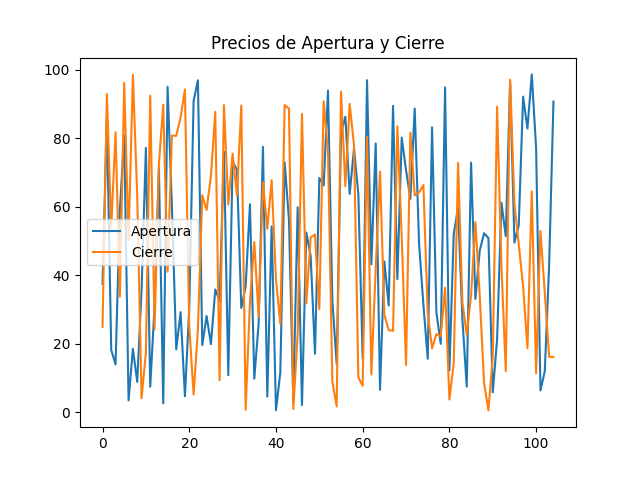

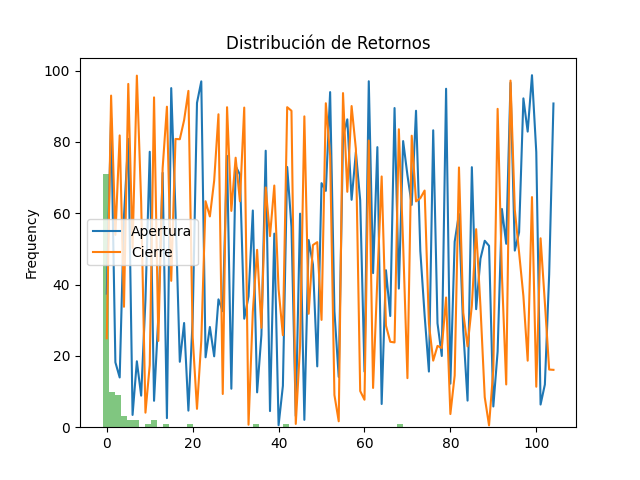

In [ ]:
# Ejemplo de cómo calcular estadísticas descriptivas:
print(acciones[['Apertura', 'Cierre', 'retorno']].describe())

import matplotlib.pyplot as plt

acciones[['Apertura', 'Cierre']].plot(kind='line')
plt.title('Precios de Apertura y Cierre')
plt.show()

acciones['retorno'].plot(kind='hist', bins=50, alpha=0.6)
plt.title('Distribución de Retornos')
plt.show()


# Generación nuevo dataset

In [ ]:
import pandas as pd
import numpy as np

# Generar fechas de negociación
fechas = pd.date_range(start="2023-11-18", end="2023-12-09", freq='B')

# Nombres de empresas
empresas = ['Empresa ' + chr(i) for i in range(65, 75)]  # Genera nombres de Empresa A a Empresa J

# Crear DataFrame vacío
df = pd.DataFrame()

# Generar datos para cada empresa
for empresa in empresas:
    base_precio = np.random.uniform(10, 100)  # Precio base aleatorio entre 10 y 100
    precios_apertura = np.round(base_precio + np.random.randn(len(fechas)) * 2, 2)  # Varianza diaria
    cambios = np.random.randn(len(fechas)) * 2  # Cambio diario en precio
    precios_cierre = np.round(precios_apertura + cambios, 2)  # Cierre es apertura más cambio

    # Añadir los datos al DataFrame
    df_empresa = pd.DataFrame({
        'Nombre de la Empresa': empresa,
        'Fecha': fechas,
        'Apertura': precios_apertura,
        'Cierre': precios_cierre
    })
    df = pd.concat([df, df_empresa])

# Reordenar el índice después de concatenar
df.reset_index(drop=True, inplace=True)

# Guardar en CSV
df.to_csv('Dataset_Acciones_Empresas.csv', index=False)


In [ ]:
# Cargar los datos del dataset
acciones = pd.read_csv('Dataset_Acciones_Empresas.csv')

# Calcular los retornos basados en apertura y cierre
acciones['retorno'] = (acciones['Cierre'] - acciones['Apertura']) / acciones['Apertura']
#print("Retornos calculados:")
#print(acciones[['Nombre de la Empresa', 'Apertura', 'Cierre', 'retorno']].head())

# Normalizar los retornos usando Z-score
acciones['retorno_normalizado'] = (acciones['retorno'] - acciones['retorno'].mean()) / acciones['retorno'].std()
#print("Retornos normalizados:")
#print(acciones[['Nombre de la Empresa', 'retorno', 'retorno_normalizado']].head())

# Agrupar por nombre de la empresa y calcular la media de los retornos diarios
retornos = acciones.groupby('Nombre de la Empresa')['retorno'].mean().reset_index()
#print("Retornos medios por empresa:")
#print(retornos)

# Obtener la lista de nombres de empresas
asset_names = retornos['Nombre de la Empresa'].tolist()
retornos_esperados = retornos['retorno'].values

# Calcular la matriz de covarianza basada en los retornos diarios
retornos_diarios = acciones.pivot(index='Fecha', columns='Nombre de la Empresa', values='retorno').dropna()
cov_matrix = retornos_diarios.cov().values
#print("Matriz de covarianza de los retornos:")
#print(cov_matrix)

# El último precio de cierre de cada empresa es el precio de compra !!
precios_cierre = acciones.groupby('Nombre de la Empresa')['Cierre'].last()
#print("Precios de cierre de cada empresa:")
#print(precios_cierre)

# Obtener cantidad de activos N basado en los nombres de las empresas
n_assets = len(asset_names)

# Umbral de retorno mínimo
retorno_minimo = 0.001

# Presupuesto total disponible para inversión
presupuesto_total = 200

# Calcular el número máximo de unidades para cada acción basado en el presupuesto y el precio de cierre para que no se invierta solo en una empresa
max_unidades = (presupuesto_total / precios_cierre).astype(int)

# Calcular n_bits para cada acción basado en max_unidades
n_bits = [int(np.ceil(np.log2(unidades + 1))) for unidades in max_unidades]
#print("Número máximo de unidades y bits necesarios para cada empresa:")
#for nombre, bits, unidades in zip(precios_cierre.index, n_bits, max_unidades):
#    print(f"{nombre}: max_unidades={unidades}, n_bits={bits}")

# Función para construir el modelo QUBO
def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, precios_cierre, n_bits):
    var_problema = [BitArrayShape(f'x_{i}', (n_bits[i],)) for i in range(n_assets)]

    slack_presupuesto_max = presupuesto
    slack_retorno_max = np.sum(precios_cierre * (2**np.array(n_bits) - 1))

    my_var_slack_presupuesto = VarSlack(name='slack_presupuesto', start=0, step=1, stop=slack_presupuesto_max, slack_type=SlackType.binary)
    my_var_slack_retorno = VarSlack(name='slack_retorno', start=0, step=1, stop=slack_retorno_max, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(*var_problema, my_var_slack_presupuesto, my_var_slack_retorno)

    BinPol.freeze_var_shape_set(var_shape_set)

    H_cuad = BinPol()

    # Minimización de la varianza de la cartera
    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits[i]):
                for l in range(n_bits[j]):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l) * (precios_cierre.iloc[i] * precios_cierre.iloc[j])
                    H_cuad.add_term(w_ij, (f'x_{i}', k), (f'x_{j}', l))

    H_slack = BinPol()

    # Restricción de retorno mínimo
    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_slack.add_term(-retornos[i] * (2**k) * precios_cierre.iloc[i], (f'x_{i}', k))
    H_slack.add_slack_variable('slack_retorno', factor=1)
    H_slack.add_term(retorno_min_esperado, ())

    H_budget = BinPol()

    # Restricción de presupuesto
    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_budget.add_term((2**k) * precios_cierre.iloc[i], (f'x_{i}', k))
    H_budget.add_slack_variable('slack_presupuesto', factor=1)
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    # Combinación de los términos del QUBO
    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty
    return QUBO, H_cuad, H_slack, H_budget

# Ajuste del factor de penalización
factor_penalty = 10000  # Incrementar significativamente el factor de penalización
QUBO, H_cuad, H_slack, H_budget = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo, presupuesto_total, precios_cierre, n_bits)

solver = QUBOSolverCPU(
    number_iterations=100000,
    number_runs=10,
    scaling_bit_precision=16,
    auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
)

solution_list = solver.minimize(QUBO)
print("Mejor configuración encontrada:")
print(solution_list.min_solution.configuration)
print()
print("Tiempos del solver:")
print(solution_list.solver_times)

def prep_result(solution_list, H_budget, H_slack, silent=False):
    solution = solution_list.min_solution
    budget_penalty = H_budget.compute(solution.configuration)
    slack_penalty = H_slack.compute(solution.configuration)
    total_penalty = budget_penalty + slack_penalty
    if not silent:
        print(f'Valor QUBO: {total_penalty}')
        print('Detalle de la configuración:', solution.configuration)
    return total_penalty, solution

constraint_penalty, solution = prep_result(solution_list, H_budget, H_slack)
if constraint_penalty == 0:
    print("La solución cumple todas las restricciones.")
else:
    print("La solución no cumple con todas las restricciones, penalización total:", constraint_penalty)

def es_factible(retornos, retorno_min_esperado, n_assets):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:n_assets])
    return retorno_posible_max >= retorno_min_esperado

# Uso de las funciones actualizadas con la ejecución del modelo QUBO
if not es_factible(retornos_esperados, retorno_minimo, n_assets):
    print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
else:
    constraint_penalty, solution = prep_result(solution_list, H_budget, H_slack)
    if constraint_penalty == 0:
        print("La solución cumple todas las restricciones.")
        selected_assets = []
        idx = 0
        for i in range(len(asset_names)):
            cantidad = sum(solution.configuration[idx + k] * (2**k) for k in range(n_bits[i]))
            if cantidad > 0:
                selected_assets.append((asset_names[i], cantidad))
            idx += n_bits[i]
        print("Portfolio elegido:", selected_assets)
    else:
        print(f"No se puede dar solución con las restricciones dadas, penalización: {constraint_penalty}")


Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00005
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1452.000
  temperature_end:                   114.400
  offset_increase_rate:              344.400
  duration:                            0.004 sec
********************************************************************************

Attention: 1 coefficient has been rounded to 0!
[WARNING] The coefficient 0.4525945822816385 of ('slack_retorno', 0) has been rounded to 0!
Attention: Found 1 not used bit! <make_qubo>
[WARNING] The bit ('slack_retorno', 0) is not used!
Mejor configuración encontrada:
[1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0

In [ ]:

# Cargar y preparar los datos
acciones = pd.read_csv('Dataset_Acciones_Empresas.csv')
acciones['retorno'] = (acciones['Cierre'] - acciones['Apertura']) / acciones['Apertura']
acciones['retorno_normalizado'] = (acciones['retorno'] - acciones['retorno'].mean()) / acciones['retorno'].std()
retornos = acciones.groupby('Nombre de la Empresa')['retorno'].mean().reset_index()
asset_names = retornos['Nombre de la Empresa'].tolist()
retornos_esperados = retornos['retorno'].values
retornos_diarios = acciones.pivot(index='Fecha', columns='Nombre de la Empresa', values='retorno').dropna()
cov_matrix = retornos_diarios.cov().values
precios_cierre = acciones.groupby('Nombre de la Empresa')['Cierre'].last()
n_assets = len(asset_names)
retorno_minimo = 0.001
presupuesto_total = 200
max_unidades = (presupuesto_total / precios_cierre).astype(int)
n_bits = [int(np.ceil(np.log2(unidades + 1))) for unidades in max_unidades]

print("Datos cargados y preparados correctamente.")

def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, precios_cierre, n_bits):
    var_problema = [BitArrayShape(f'x_{i}', (n_bits[i],)) for i in range(n_assets)]

    slack_presupuesto_max = presupuesto
    slack_retorno_max = np.sum(precios_cierre * (2**np.array(n_bits) - 1))

    my_var_slack_presupuesto = VarSlack(name='slack_presupuesto', start=0, step=1, stop=slack_presupuesto_max, slack_type=SlackType.binary)
    my_var_slack_retorno = VarSlack(name='slack_retorno', start=0, step=1, stop=slack_retorno_max, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(*var_problema, my_var_slack_presupuesto, my_var_slack_retorno)
    BinPol.freeze_var_shape_set(var_shape_set)

    H_cuad = BinPol()

    # Minimización de la varianza de la cartera
    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits[i]):
                for l in range(n_bits[j]):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l) * (precios_cierre.iloc[i] * precios_cierre.iloc[j])
                    H_cuad.add_term(w_ij, (f'x_{i}', k), (f'x_{j}', l))

    H_slack = BinPol()

    # Restricción de retorno mínimo
    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_slack.add_term(retornos[i] * (2**k) * precios_cierre.iloc[i], (f'x_{i}', k))
    H_slack.add_slack_variable('slack_retorno', factor=1)
    H_slack.add_term(-retorno_min_esperado, ())

    H_budget = BinPol()

    # Restricción de presupuesto
    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_budget.add_term((2**k) * precios_cierre.iloc[i], (f'x_{i}', k))
    H_budget.add_slack_variable('slack_presupuesto', factor=1)
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    # Combinación de los términos del QUBO
    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty
    return QUBO, H_cuad, H_slack, H_budget

# Ajuste del factor de penalización
factor_penalty = 100000  # Ajustar el factor de penalización para asegurar el cumplimiento de restricciones
QUBO, H_cuad, H_slack, H_budget = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo, presupuesto_total, precios_cierre, n_bits)

solver = QUBOSolverCPU(
    number_iterations=100000,
    number_runs=10,
    scaling_bit_precision=16,
    auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
)

solution_list = solver.minimize(QUBO)
print("Mejor configuración encontrada:")
print(solution_list.min_solution.configuration)
print()
print("Tiempos del solver:")
print(solution_list.solver_times)

def prep_result(solution_list, H_budget, H_slack, silent=False):
    solution = solution_list.min_solution
    budget_penalty = H_budget.compute(solution.configuration)
    slack_penalty = H_slack.compute(solution.configuration)
    total_penalty = budget_penalty + slack_penalty
    if not silent:
        print(f'Valor QUBO: {total_penalty}')
        print('Detalle de la configuración:', solution.configuration)
    return total_penalty, solution

constraint_penalty, solution = prep_result(solution_list, H_budget, H_slack)
if constraint_penalty == 0:
    print("La solución cumple todas las restricciones.")
else:
    print("La solución no cumple con todas las restricciones, penalización total:", constraint_penalty)

def es_factible(retornos, retorno_min_esperado, n_assets):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:n_assets])
    return retorno_posible_max >= retorno_min_esperado

if not es_factible(retornos_esperados, retorno_minimo, n_assets):
    print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
else:
    constraint_penalty, solution = prep_result(solution_list, H_budget, H_slack)
    if constraint_penalty == 0:
        print("La solución cumple todas las restricciones.")
        selected_assets = []
        idx = 0
        for i in range(len(asset_names)):
            cantidad = sum(solution.configuration[idx + k] * (2**k) for k in range(n_bits[i]))
            if cantidad > 0:
                selected_assets.append((asset_names[i], cantidad))
            idx += n_bits[i]
        print("Portfolio elegido:", selected_assets)
    else:
        print(f"No se puede dar solución con las restricciones dadas, penalización: {constraint_penalty}")


Datos cargados y preparados correctamente.
Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00000
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                1435.000
  temperature_end:                   113.000
  offset_increase_rate:              340.200
  duration:                            0.004 sec
********************************************************************************

Attention: 1 coefficient has been rounded to 0!
[WARNING] The coefficient 0.4525945771177125 of ('slack_retorno', 0) has been rounded to 0!
Attention: Found 1 not used bit! <make_qubo>
[WARNING] The bit ('slack_retorno', 0) is not used!
Mejor configuración e

In [ ]:

# Cargar y preparar los datos
acciones = pd.read_csv('Dataset_Acciones_Empresas.csv')
acciones['retorno'] = (acciones['Cierre'] - acciones['Apertura']) / acciones['Apertura']
retornos = acciones.groupby('Nombre de la Empresa')['retorno'].mean().reset_index()
asset_names = retornos['Nombre de la Empresa'].tolist()
retornos_esperados = retornos['retorno'].values
retornos_diarios = acciones.pivot(index='Fecha', columns='Nombre de la Empresa', values='retorno').dropna()
cov_matrix = retornos_diarios.cov().values
precios_cierre = acciones.groupby('Nombre de la Empresa')['Cierre'].last().values
n_assets = len(asset_names)
retorno_minimo = 0.001
presupuesto_total = 200
max_unidades = (presupuesto_total / precios_cierre).astype(int)
n_bits = [int(np.ceil(np.log2(unidades + 1))) for unidades in max_unidades]

print("Datos cargados y preparados correctamente.")

def build_qubo(cov_matrix, n_assets, factor_penalty, retornos, retorno_min_esperado, presupuesto, precios_cierre, n_bits):
    var_problema = [BitArrayShape(f'x_{i}', (n_bits[i],)) for i in range(n_assets)]

    slack_presupuesto_max = presupuesto
    slack_retorno_max = retorno_min_esperado

    my_var_slack_presupuesto = VarSlack(name='slack_presupuesto', start=0, step=1, stop=slack_presupuesto_max, slack_type=SlackType.binary)
    my_var_slack_retorno = VarSlack(name='slack_retorno', start=0, step=1, stop=slack_retorno_max, slack_type=SlackType.binary)

    var_shape_set = VarShapeSet(*var_problema, my_var_slack_presupuesto, my_var_slack_retorno)
    BinPol.freeze_var_shape_set(var_shape_set)

    H_cuad = BinPol()

    # Minimización de la varianza de la cartera
    for i in range(n_assets):
        for j in range(n_assets):
            for k in range(n_bits[i]):
                for l in range(n_bits[j]):
                    w_ij = cov_matrix[i, j] * (2**k) * (2**l)
                    H_cuad.add_term(w_ij, (f'x_{i}', k), (f'x_{j}', l))

    H_slack = BinPol()

    # Restricción de retorno mínimo
    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_slack.add_term(retornos[i] * (2**k), (f'x_{i}', k))
    H_slack.add_slack_variable('slack_retorno', factor=-1)
    H_slack.add_term(-retorno_min_esperado, ())

    H_budget = BinPol()

    # Restricción de presupuesto
    for i in range(n_assets):
        for k in range(n_bits[i]):
            H_budget.add_term((2**k) * precios_cierre[i], (f'x_{i}', k))
    H_budget.add_slack_variable('slack_presupuesto', factor=1)
    H_budget.add_term(-presupuesto, ())
    H_budget.power(2)

    # Combinación de los términos del QUBO
    QUBO = H_cuad + (H_slack + H_budget) * factor_penalty
    return QUBO, H_cuad, H_slack, H_budget

# Ajuste del factor de penalización
factor_penalty = 1000000  # Incrementar el factor de penalización para asegurar el cumplimiento de restricciones
QUBO, H_cuad, H_slack, H_budget = build_qubo(cov_matrix, n_assets, factor_penalty, retornos_esperados, retorno_minimo, presupuesto_total, precios_cierre, n_bits)

solver = QUBOSolverCPU(
    number_iterations=100000,
    number_runs=10,
    scaling_bit_precision=16,
    auto_tuning=AutoTuning.AUTO_SCALING_AND_SAMPLING
)

solution_list = solver.minimize(QUBO)
print("Mejor configuración encontrada:")
print(solution_list.min_solution.configuration)
print()
print("Tiempos del solver:")
print(solution_list.solver_times)

def prep_result(solution_list, H_budget, H_slack, silent=False):
    solution = solution_list.min_solution
    budget_penalty = H_budget.compute(solution.configuration)
    slack_penalty = H_slack.compute(solution.configuration)
    total_penalty = budget_penalty + slack_penalty
    if not silent:
        print(f'Valor QUBO: {total_penalty}')
        print('Detalle de la configuración:', solution.configuration)
    return total_penalty, solution

constraint_penalty, solution = prep_result(solution_list, H_budget, H_slack)
if constraint_penalty == 0:
    print("La solución cumple todas las restricciones.")
else:
    print("La solución no cumple con todas las restricciones, penalización total:", constraint_penalty)

def es_factible(retornos, retorno_min_esperado, n_assets):
    retorno_posible_max = sum(sorted(retornos, reverse=True)[:n_assets])
    return retorno_posible_max >= retorno_min_esperado

if not es_factible(retornos_esperados, retorno_minimo, n_assets):
    print(f"No se puede dar solución para el retorno mínimo introducido de {retorno_minimo}")
else:
    constraint_penalty, solution = prep_result(solution_list, H_budget, H_slack)
    if constraint_penalty < 0.2:
        print("La solución cumple todas las restricciones.")
        selected_assets = []
        idx = 0
        for i in range(len(asset_names)):
            cantidad = sum(solution.configuration[idx + k] * (2**k) for k in range(n_bits[i]))
            if cantidad > 0:
                selected_assets.append((asset_names[i], cantidad))
            idx += n_bits[i]
        print("Portfolio elegido:", selected_assets)
    else:
        print(f"No se puede dar solución con las restricciones dadas, penalización: {constraint_penalty}")


Datos cargados y preparados correctamente.
Attention: Downscaling!

********************************************************************************
Scaling qubo, temperature_start, temperature_end and offset_increase_rate
  factor:                            0.00000
********************************************************************************


********************************************************************************
Effective values (including scaling factor)
  temperature_start:                2194.000
  temperature_end:                   144.600
  offset_increase_rate:              459.300
  duration:                            0.005 sec
********************************************************************************

Mejor configuración encontrada:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]

Tiempos del solver:
+--------------+----------------------------+----------------------------+----------------+
| time 